# Inspect & Compare Feature Importance

...

**Data Sources**

- `feature_names`: List of column labels for preprocessed data.
- `models/full_pipe_final.pkl`: Best pipeline / model.
- `data/interim/train_opti_EN` / `data/interim/y_train_EN`: Preprocessed training data for Elastic Net.
- `data/interim/features_XGB` / `data/interim/features_XGB`: Preprocessed full data (best suited for XGB).


**Changes**

- 2019-04-04: Start notebook and complete section for ElasticNet model
- 2019-04-13: Add section for XGB and finish notebook


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Inspect-Feature-Importance-for-ElasticNet-Model" data-toc-modified-id="Inspect-Feature-Importance-for-ElasticNet-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inspect Feature Importance for ElasticNet Model</a></span><ul class="toc-item"><li><span><a href="#Calculate-Coefficent-Weights" data-toc-modified-id="Calculate-Coefficent-Weights-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate Coefficent Weights</a></span></li><li><span><a href="#Apply-Recursive-Feature-Elimination-With-Cross-Validation-(RFECV)" data-toc-modified-id="Apply-Recursive-Feature-Elimination-With-Cross-Validation-(RFECV)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Apply Recursive Feature Elimination With Cross Validation (RFECV)</a></span></li><li><span><a href="#Apply-Permuation-Importance" data-toc-modified-id="Apply-Permuation-Importance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Apply Permuation Importance</a></span></li></ul></li><li><span><a href="#Inspect-Feature-Importance-for-XGB-Model" data-toc-modified-id="Inspect-Feature-Importance-for-XGB-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inspect Feature Importance for XGB Model</a></span><ul class="toc-item"><li><span><a href="#Using-Built-in-XGBoost-Feature-Importance-Plot" data-toc-modified-id="Using-Built-in-XGBoost-Feature-Importance-Plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Using Built-in XGBoost Feature Importance Plot</a></span></li><li><span><a href="#Manually-Inspect-Feature-Importance" data-toc-modified-id="Manually-Inspect-Feature-Importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Manually Inspect Feature Importance</a></span></li><li><span><a href="#Explain-with-eli5-Library" data-toc-modified-id="Explain-with-eli5-Library-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Explain with eli5 Library</a></span></li></ul></li><li><span><a href="#Compare-Top-15-features-for-the-2-models" data-toc-modified-id="Compare-Top-15-features-for-the-2-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare Top-15 features for the 2 models</a></span></li><li><span><a href="#Appendix:-Re-fit-and-Re-evaluate-XGB-with-Reduced-Feature-Set" data-toc-modified-id="Appendix:-Re-fit-and-Re-evaluate-XGB-with-Reduced-Feature-Set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix: Re-fit and Re-evaluate XGB with Reduced Feature Set</a></span><ul class="toc-item"><li><span><a href="#Hands-on-Approach" data-toc-modified-id="Hands-on-Approach-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Hands-on Approach</a></span></li><li><span><a href="#Feature-Selection-Using-XGBoost-Feature-Importance" data-toc-modified-id="Feature-Selection-Using-XGBoost-Feature-Importance-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Selection Using XGBoost Feature Importance</a></span></li></ul></li></ul></div>

---

## Import libraries, load data

In [55]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import ElasticNet
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, SelectFromModel

import eli5
from eli5.sklearn import PermutationImportance
from eli5 import explain_weights_xgboost

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel
import custom_transformers as transform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
# Load labels, data and model
%store -r feature_names
%store -r feature_names_XGB

elastic_net_final = joblib.load('models/elastic_net_final.pkl')
XGB_final = joblib.load('models/XGB_final.pkl')

EN_train = pd.read_csv('data/interim/train_opti_EN')
EN_labels = pd.read_csv('data/interim/y_train_EN')

XGB_features = pd.read_csv('data/interim/features_XGB')
XGB_labels = pd.read_csv('data/interim/labels_XGB')

## Inspect Feature Importance for ElasticNet Model
### Calculate Coefficent Weights

In [3]:
def get_coef_weights(model, feature_names, drop_zero=False):
    ''' Returns DataFrame with coefficient weights for the features. If 
    drop_zero ist True, then only features with weights != 0 are returned.
    
    ARGUMENTS:
    model: fitted model instance
    feature_names: list or index of column_labels
    drop_zero: bool, drop coefs with 0 weight (default=False)

    RETURNS:
    coefs_df: dataframe holding coeff weights and error
    '''
    
    coefs_df = pd.DataFrame(model.coef_, 
                            index=feature_names, 
                            columns=['weight']
                           )
    
    # Sort by absolute weights
    coefs_df['abs_weight'] = np.abs(coefs_df['weight'])
    coefs_df = coefs_df.sort_values('abs_weight', ascending=False)
    coefs_df.drop('abs_weight', axis=1, inplace=True)
    
    if drop_zero == True:
        coefs_df = coefs_df.loc[coefs_df['weight'] != 0]
    
    return coefs_df

In [4]:
EN_weights = get_coef_weights(elastic_net_final, feature_names, drop_zero=True)

In [5]:
def plot_coef_weights(coefs_df, feature_names, n_plot=30):
    """(Note: feature_names is only used for percentage calculation.)"""
    
    plt.figure(figsize=(12, 8))
    plt.title("Top-{0:d} features".format(n_plot), size=14)
    coefs_df.iloc[:n_plot, 0].apply(np.abs).plot(kind='bar', color=color)
    
    n_features = len(feature_names)
    n_weights = len(coefs_df.loc[coefs_df['weight'] != 0])
    print('\n{0:d} features remaining with weight > 0, \
    \nthis equals a reduction of {1:2.2f}%'.format(
            n_weights, (1 - (n_weights / n_features)) * 100))
 


102 features remaining with weight > 0,     
this equals a reduction of 66.88%


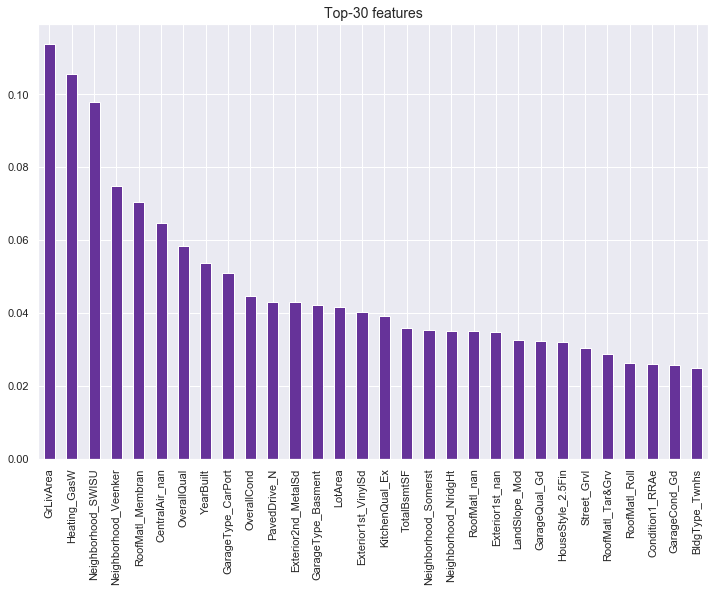

In [6]:
plot_coef_weights(EN_weights, feature_names)

In [7]:
# Note contrary to weights in e.g. a Random Forest Model the coef weights here do not add up to 1
# That's why I divide by the cum_total in the plot statements

def plot_coef_weights_advanced(coefs_df, n_plot=15):
    
    cum_total = np.cumsum(coefs_df.iloc[:,0])[-1]
    coefs_df = pd.DataFrame(coefs_df.iloc[:n_plot, 0].apply(np.abs))
    
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.bar(np.arange(len(coefs_df)), coefs_df.iloc[:, 0] / cum_total, width = 0.5, align="center", 
            color = 'yellow', label = "Feature Weight")
    plt.bar(np.arange(len(coefs_df)) - 0.3, np.cumsum(coefs_df.iloc[:, 0]) / cum_total, width = 0.4, 
            align = "center", color = 'rebeccapurple', label = "Cumulative Feature Weights")
    
    # styling
    plt.title("Top-{0:d} features, with cumulative weights".format(n_plot), size=14)
    plt.ylabel("Prop of total coef weights")
    plt.xlabel("Features / Attributes")
    plt.xticks(np.arange(len(coefs_df)), coefs_df.index, rotation=90)
    plt.legend(loc = 'upper left');
    
    cum_prop = np.cumsum(coefs_df.iloc[:,0])[-1] / cum_total
    print("\nTop-{0:d} features explain {1:2.2f}% of the total coef weights".format(
            n_plot, cum_prop*100))


Top-20 features explain 129.98% of the total coef weights


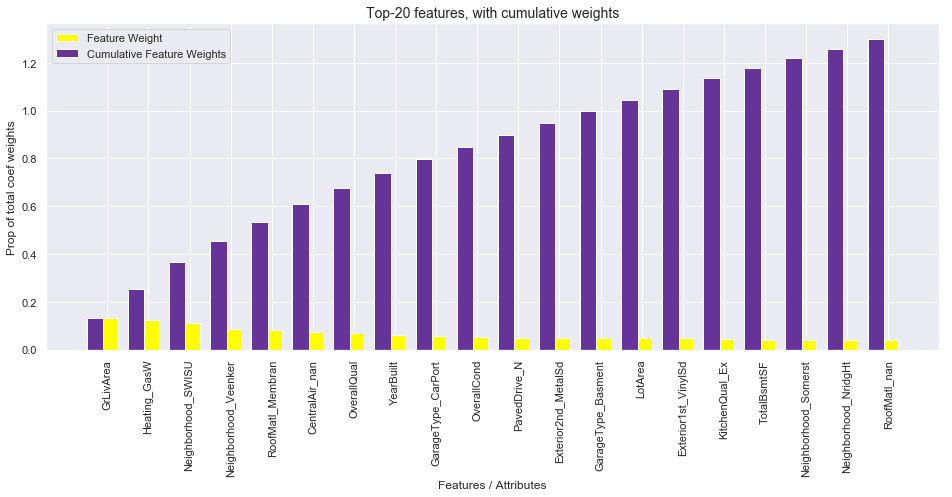

In [8]:
plot_coef_weights_advanced(EN_weights, n_plot=20)



**Re-examine feature importance with cumulative weights for categorical features:**

In [9]:
# Split feature names into category and sub-category
EN_weights['category'] = EN_weights.index.str.split('_').str.get(0)
EN_weights['sub_category'] = EN_weights.index.str.split('_').str.get(-1)
# Group by category and sum the weights
EN_weights['weight'] = EN_weights['weight'].apply(np.abs)
EN_weights_cum = EN_weights.groupby('category').sum()
EN_weights_cum.sort_values('weight', ascending=False, inplace=True)


Top-15 features explain 66.82% of the total coef weights


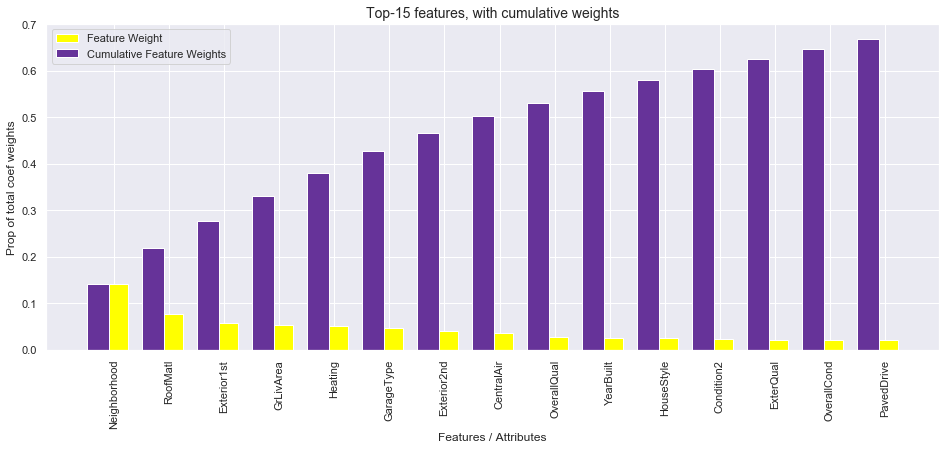

In [10]:
plot_coef_weights_advanced(EN_weights_cum)

In [11]:
test_weights = get_coef_weights(elastic_net_final, feature_names)
len(test_weights)

308

### Apply Recursive Feature Elimination With Cross Validation (RFECV)

[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) performs RFE in a cross-validation loop to find the optimal number of features.

Optimal number of features : 80


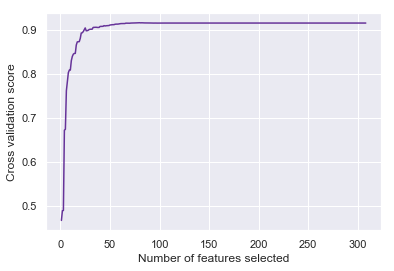

In [12]:
# # Create the RFE object and compute a cross-validated score
rfecv = RFECV(estimator=elastic_net_final, step=1, cv=3)
rfecv.fit(EN_train, pd.Series(EN_labels['SalePrice']))

print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color=color);

In [13]:
# Create DataFrame of feature names with rfecv-rank as index
rfecv_ranking = pd.DataFrame(feature_names, index=rfecv.ranking_).sort_index()
rfecv_ranking.head()

,0
1,Exterior1st_HdBoard
1,LandSlope_Mod
1,Exterior1st_nan
1,LotConfig_nan
1,Exterior2nd_HdBoard


In [14]:
rfecv_ranking.index.value_counts().head()

1     80
85     1
83     1
82     1
81     1
dtype: int64

**Observation:** All the 80 features that lead to the optimal scoring have rank 1.

In [15]:
# Check if the top-ranked 102 features are the same ones as 
# those above with abs weight > 0
top_ranked_rfecv = list(rfecv_ranking.iloc[:102, 0])
set(top_ranked_rfecv).difference(set(EN_weights.index))

set()

**Conclusion:** RFECV is not ideal to inspect feature importance because all features that are within the range of an optimal prediction have the same rank. But in another project I should apply it in a preprocessing pipeline to select the best features.

### Apply Permuation Importance

See [here](https://www.kaggle.com/dansbecker/permutation-importance) for an explanation.

In [16]:
perm = PermutationImportance(elastic_net_final, random_state=1).fit(EN_train, EN_labels)
eli5.show_weights(perm, feature_names = list(feature_names))

Weight,Feature
0.2155 ± 0.0080,GrLivArea
0.0556 ± 0.0052,OverallQual
0.0485 ± 0.0070,YearBuilt
0.0350 ± 0.0067,OverallCond
0.0292 ± 0.0047,LotArea
0.0230 ± 0.0020,TotalBsmtSF
0.0088 ± 0.0023,BsmtFinSF1
0.0087 ± 0.0017,Heating_GasW
0.0076 ± 0.0003,GarageArea
0.0056 ± 0.0015,Fireplaces


**Interpreting Permutation Importances:**
The values towards the top are the most important features, and those towards the bottom matter least.
The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

**Observation:** There is some overlap with the features that have biggest coef weights, but there are also some 'new' features here like 'GarageArea' or 'Fireplaces'.


## Inspect Feature Importance for XGB Model

### Using Built-in XGBoost Feature Importance Plot

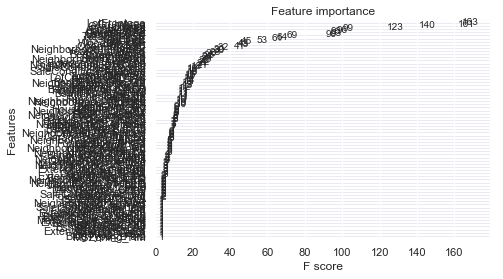

In [17]:
plot_importance(XGB_final);

This is not supposed to look this way ... maybe to many features?

### Manually Inspect Feature Importance

**Note:** I re-use the plot functions from above, knowing that the function names, titles, ax descriptions are not totally correct, as we are not inspecting coef weights this time.

In [18]:
# Look at feature importances of fitted model
XGB_final.feature_importances_[:5]

array([0.00046042, 0.00045067, 0.00424862, 0.11672346, 0.00260902],
      dtype=float32)

In [19]:
def get_feature_importances(model, feature_names, drop_zero=False):
    ''' Returns DataFrame with coefficient weights for the features. If 
    drop_zero ist True, then only features with weights != 0 are returned.
    (This model has a little different syntax as the one above.)
    
    ARGUMENTS:
    model: fitted XGBoost model instance
    feature_names: list or index of column_labels
    drop_zero: bool, drop coefs with 0 weight (default=False)

    RETURNS:
    coefs_df: dataframe holding coeff weights and error
    '''
    
    coefs_df = pd.DataFrame(model.feature_importances_,  # syntax change
                            index=feature_names, 
                            columns=['weight']
                           )
    
    # Sort by absolute weights
    coefs_df['abs_weight'] = np.abs(coefs_df['weight'])
    coefs_df = coefs_df.sort_values('abs_weight', ascending=False)
    coefs_df.drop('abs_weight', axis=1, inplace=True)
    
    if drop_zero == True:
        coefs_df = coefs_df.loc[coefs_df['weight'] != 0]
    
    return coefs_df

In [20]:
XGB_importances = get_feature_importances(XGB_final, feature_names_XGB, drop_zero=True)


147 features remaining with weight > 0,     
this equals a reduction of 52.27%


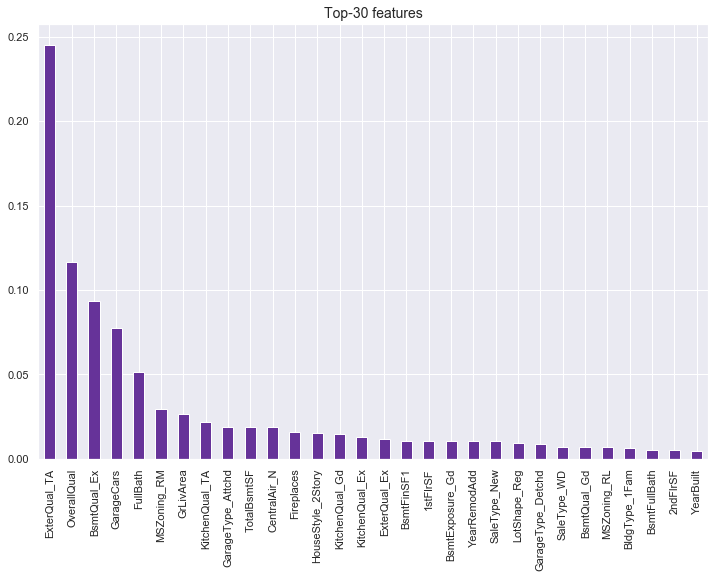

In [21]:
plot_coef_weights(XGB_importances, feature_names_XGB)


Top-15 features explain 77.76% of the total coef weights


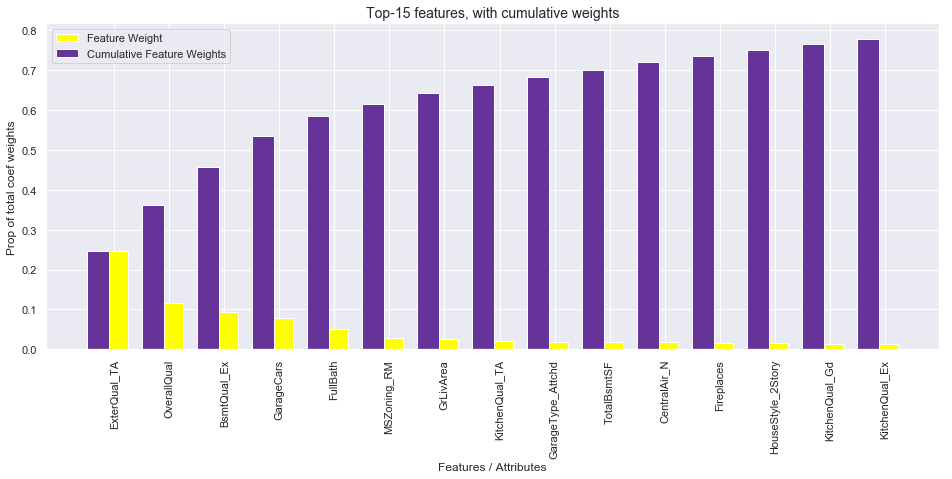

In [22]:
plot_coef_weights_advanced(XGB_importances)

In [23]:
# Split feature names into category and sub-category
XGB_importances['category'] = XGB_importances.index.str.split('_').str.get(0)
XGB_importances['sub_category'] = XGB_importances.index.str.split('_').str.get(-1)
# Group by category and sum the weights
XGB_importances['weight'] = XGB_importances['weight'].apply(np.abs)
XGB_importances_cum = XGB_importances.groupby('category').sum()
XGB_importances_cum.sort_values('weight', ascending=False, inplace=True)


Top-15 features explain 85.21% of the total coef weights


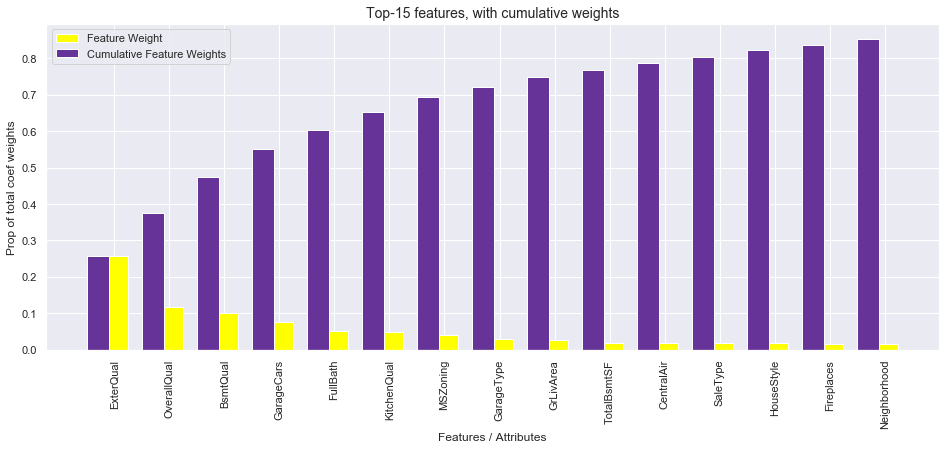

In [24]:
plot_coef_weights_advanced(XGB_importances_cum)

### Explain with eli5 Library

In [40]:
# One can also have this  with eli5
explain_weights_xgboost(XGB_final, vec=None, top=20, target_names=None, 
                        targets=None, feature_names=None, feature_re=None, 
                        feature_filter=None, importance_type='gain')

Weight,Feature
0.2453,ExterQual_TA
0.1167,OverallQual
0.0936,BsmtQual_Ex
0.0776,GarageCars
0.0515,FullBath
0.0296,MSZoning_RM
0.0268,GrLivArea
0.0216,KitchenQual_TA
0.0189,GarageType_Attchd
0.0188,TotalBsmtSF


In [44]:
# The nice thing is that eli5 can also explain single predictions
explain_prediction_xgboost(XGB_final, XGB_features.iloc[0])

Explanation(estimator="XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n       colsample_bytree=1, gamma=0, importance_type='gain',\n       learning_rate=0.08, max_delta_step=0, max_depth=3,\n       min_child_weight=1, missing=nan, n_estimators=500, n_jobs=1,\n       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,\n       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,\n       subsample=1)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=180411.97411837656, std=None, value=1.0), FeatureWeight(feature='OverallQual', weight=11802.96942475478, std=None, value=7.0), FeatureWeight(feature='2ndFlrSF', weight=4752.0754930985595, std=None, value=854.0), FeatureWeight(feature='ExterQual_TA', weight=3479.7806944093545, std=None, value=0.0), FeatureWeight(feature='BsmtFullBath', weight=3409.627807767085, std=None, value=1.0), FeatureWeight(feature='YearRemodAdd', weight=3237.036669405688, std=None, value=2003.0), FeatureWeight(feature='FullBath', weight=3199.2231935893524, std=None, value=2.0), FeatureWeight(feature='YearBuilt', weight=2706.791377717138, std=None, value=2003.0), FeatureWeight(feature='HalfBath', weight=1395.370353591852, std=None, value=1.0), FeatureWeight(feature='KitchenQual_TA', weight=1354.2381507692298, std=None, value=0.0), FeatureWeight(feature='GarageType_Attchd', weight=1351.5477707815235, std=None, value=1.0), FeatureWeight(feature='BsmtFinType1_GLQ', weight=1226.511993868099, std=None, value=1.0), FeatureWeight(feature='KitchenQual_Gd', weight=1165.3106270535964, std=None, value=1.0), FeatureWeight(feature='HeatingQC_Ex', weight=887.5768086999695, std=None, value=1.0), FeatureWeight(feature='BsmtQual_Gd', weight=761.4617962316393, std=None, value=1.0), FeatureWeight(feature='SaleCondition_Abnorml', weight=521.0666686136163, std=None, value=0.0), FeatureWeight(feature='HouseStyle_1Story', weight=507.19535442706643, std=None, value=0.0), FeatureWeight(feature='HouseStyle_2Story', weight=496.70257367171746, std=None, value=1.0), FeatureWeight(feature='GarageYrBlt', weight=431.5374307046402, std=None, value=2003.0), FeatureWeight(feature='MSZoning_RM', weight=422.71092785714245, std=None, value=0.0), FeatureWeight(feature='MSSubClass', weight=401.7268763636366, std=None, value=60.0), FeatureWeight(feature='GarageType_Detchd', weight=400.93202905546786, std=None, value=0.0), FeatureWeight(feature='Condition1_Norm', weight=362.35774520866164, std=None, value=1.0), FeatureWeight(feature='OpenPorchSF', weight=317.85565650350014, std=None, value=61.0), FeatureWeight(feature='BsmtUnfSF', weight=307.3358302389458, std=None, value=150.0), FeatureWeight(feature='Neighborhood_OldTown', weight=299.9495601059212, std=None, value=0.0), FeatureWeight(feature='LotAre

In [45]:
# I have not yet figured out how to use Permutation Importance with XGBoost as it is not an sklearn object


## Compare Top-15 features for the 2 models

In [ ]:
print(EN_weights_cum[:15])
print(XGB_importances_cum[:15])

In [ ]:
# Print intersection of top-15 features
print(set(EN_weights_cum.index[:15]).intersection(set(XGB_importances_cum.index[:15])))

**Observation:** The two models share roughly half (7 out of 15) of their most important features.

## Appendix: Re-fit and Re-evaluate XGB with Reduced Feature Set

### Hands-on Approach

In [52]:
# Use the top 147 features
X_reduced = XGB_features[XGB_importances.index[:147]]
y = XGB_labels

# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(X_reduced, y, test_size = 0.2, random_state = 666)

In [53]:
# Initialize reduced model (same params as final model)
XGB_reduced = XGBRegressor(learning_rate=0.08, n_estimators=500)

# Fit and predict (with early stopping)
XGB_reduced.fit(X_train, y_train, 
              early_stopping_rounds=20, 
              eval_metric='rmse',
              eval_set=[(X_test, y_test)], 
              verbose=False)

y_train_pred = XGB_reduced.predict(X_train)
y_pred = XGB_reduced.predict(X_test)

# Output results
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))

train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9867767406828775
Test r2 score:  0.8877658318927117
Train RMSE: 8845.6136
Test RMSE: 28058.9851


**Observation:** The reduction in features gives a slight model improvement.

### Feature Selection Using XGBoost Feature Importance

Feature importance scores can be used for feature selection in scikit-learn. This is done using the SelectFromModel class that takes a model and can transform a dataset into a subset with selected features. This class can take a pre-trained model, such as one trained on the entire training dataset. It can then use a threshold to decide which features to select. This threshold is used when you call the transform() function on the SelectFromModel instance to consistently select the same features on the training dataset and the test dataset. In the example below we first train and then evaluate an XGBoost model on the entire
training dataset and test datasets respectively. Using the feature importances calculated from the training dataset, we then wrap the model in a SelectFromModel instance. We use this to select features on the training dataset, train a model from the selected subset of features, then evaluate the model on the testset, subject to the same feature selection scheme.

In [57]:
# First we have to get rid of the missing values a sklearn cannot handle them
cleaning.list_NaN(X_reduced)

,total,percent,dtype
LotFrontage,257,17.8,float64
GarageYrBlt,79,5.5,float64


In [60]:
X_NaN = cleaning.handle_NaN(X_reduced, cols_to_impute_num=['LotFrontage', 'GarageYrBlt'])

# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(X_NaN, y, test_size = 0.2, random_state = 666)

'LotFrontage - median value to impute: 69.0'

'GarageYrBlt - median value to impute: 1979.0'

In [63]:
# Fit model using each importance as a threshold
thresholds = np.sort(XGB_reduced.feature_importances_) 
for thresh in thresholds: 
    # select features using threshold 
    selection = SelectFromModel(XGB_reduced, threshold=thresh, prefit=True) 
    select_X_train = selection.transform(X_train) 
    # train model 
    selection_model = XGBRegressor(learning_rate=0.08, n_estimators=500) 
    selection_model.fit(select_X_train, y_train) 
    # eval model 
    select_X_test = selection.transform(X_test) 
    y_pred = selection_model.predict(select_X_test) 
    
    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_pred, y_test)
    test_rmse = np.sqrt(test_mse)
    print("Thresh={0:.3f}, n={1:d}, r2-score={2:.2f}%, rmse={3:.2f}".format(
            thresh, select_X_train.shape[1], test_r2, test_rmse))

Thresh=0.000, n=147, r2-score=0.89%, rmse=28192.29
Thresh=0.000, n=146, r2-score=0.89%, rmse=28192.03
Thresh=0.000, n=145, r2-score=0.89%, rmse=28192.03
Thresh=0.000, n=144, r2-score=0.89%, rmse=28159.13
Thresh=0.000, n=143, r2-score=0.89%, rmse=28173.02
Thresh=0.000, n=142, r2-score=0.89%, rmse=28274.56
Thresh=0.000, n=141, r2-score=0.89%, rmse=28378.78
Thresh=0.000, n=140, r2-score=0.89%, rmse=28298.94
Thresh=0.000, n=139, r2-score=0.89%, rmse=28337.90
Thresh=0.000, n=138, r2-score=0.89%, rmse=28314.28
Thresh=0.000, n=137, r2-score=0.89%, rmse=28288.63
Thresh=0.000, n=136, r2-score=0.89%, rmse=28207.77
Thresh=0.000, n=135, r2-score=0.89%, rmse=28205.68
Thresh=0.000, n=134, r2-score=0.89%, rmse=28097.08
Thresh=0.000, n=133, r2-score=0.89%, rmse=28195.48
Thresh=0.000, n=132, r2-score=0.89%, rmse=28254.59
Thresh=0.000, n=131, r2-score=0.89%, rmse=28333.90
Thresh=0.000, n=130, r2-score=0.89%, rmse=28171.74
Thresh=0.000, n=129, r2-score=0.89%, rmse=28208.11
Thresh=0.000, n=128, r2-score=0

**Observation:** The best feature set seems to be with n=86.

---